In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [5]:
class_name=os.listdir('hardware/train')
class_name


['intruder', 'rahul', 'rehan', 'swaroop']

In [14]:
class_distribution = [len(os.listdir('hardware/train/'+i)) for i in class_name]
class_distribution

[51, 51, 51, 51]

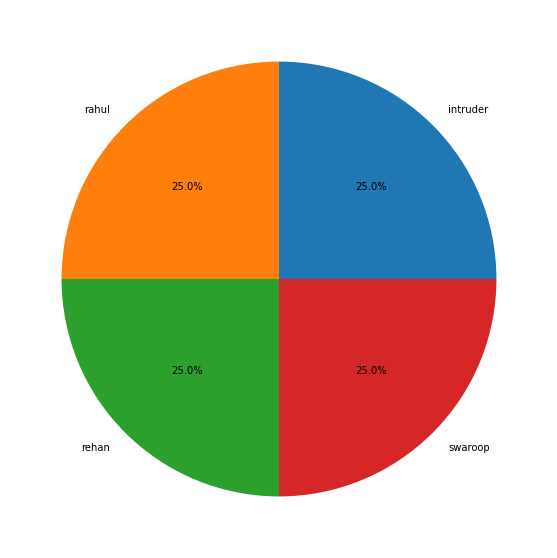

In [15]:
plt.figure(figsize=(10,10),facecolor='white')
plt.pie(class_distribution, labels=class_name, autopct='%1.1f%%')
plt.show()

In [16]:
gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=30,shear_range=0.2,brightness_range=[0.5,0.9],horizontal_flip=False,zoom_range=0.2,validation_split=0.2)
train_data=gen.flow_from_directory('hardware/train',target_size=(224,224),batch_size=32,subset='training',class_mode='categorical')
val_data=gen.flow_from_directory('hardware/train',target_size=(224,224),batch_size=32,subset='validation',class_mode='categorical')

Found 164 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


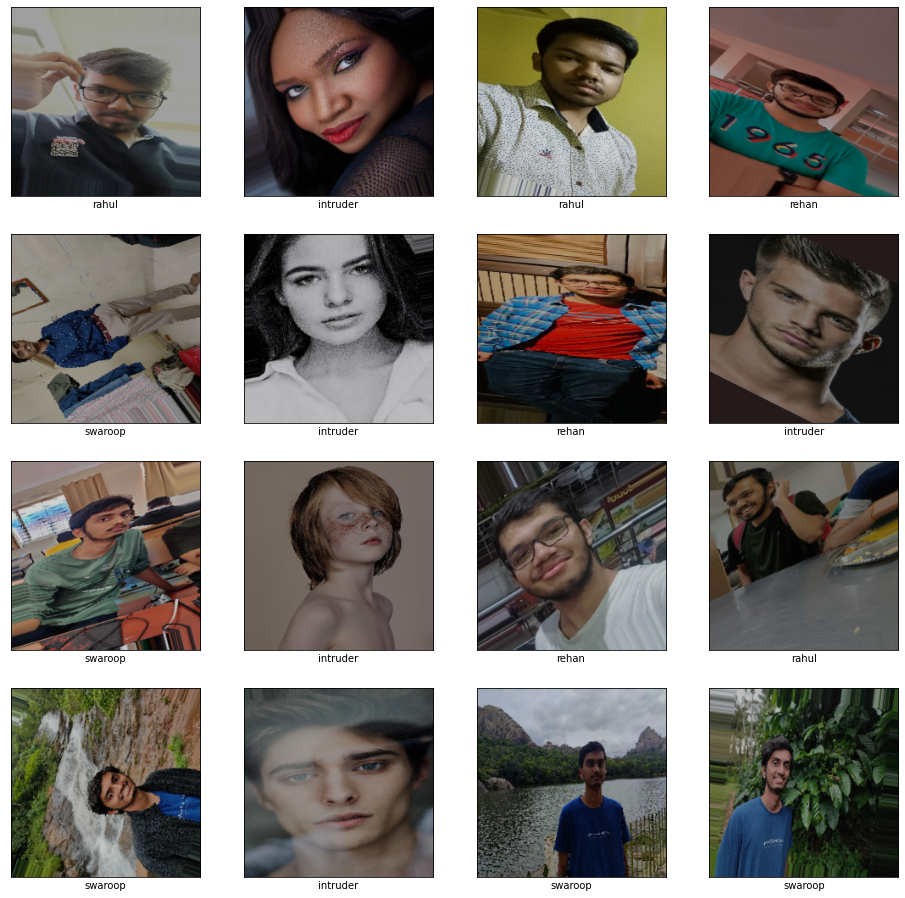

In [18]:
plt.figure(figsize=(16,16),facecolor='white')
for i in range(16):
      plt.subplot(4,4,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_data[0][0][i])
      plt.xlabel(class_name[np.argmax(train_data[0][1][i])])
plt.show()

In [19]:
model=Sequential(
    [
        Conv2D(32,activation='relu',input_shape=(224,224,3),kernel_size=5,padding='valid',strides=2),
        BatchNormalization(),
        Conv2D(64,kernel_size=3,strides=1,padding="same",activation='relu'),
        Conv2D(64,kernel_size=3,strides=1,padding="same",activation='relu'),
        MaxPooling2D(),
        Conv2D(128,kernel_size=3,strides=1,padding="same",activation='relu'),
        Conv2D(128,kernel_size=3,strides=1,padding="same",activation='relu'),
        GlobalAveragePooling2D(),
        Dense(164,activation='relu'),
        Dense(64,activation='relu'),
        Dense(len(class_name),activation='softmax'),
    ]
)

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
   ]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 128)       7

Epoch 1/50
6/6 [==============================] - 30s 4s/step - loss: 1.3661 - accuracy: 0.2927 - val_loss: 1.3851 - val_accuracy: 0.2750
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 1.2653 - accuracy: 0.4024 - val_loss: 1.3873 - val_accuracy: 0.2500
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 1.1577 - accuracy: 0.4878 - val_loss: 1.3850 - val_accuracy: 0.2000
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 1.3127 - accuracy: 0.3902 - val_loss: 1.3907 - val_accuracy: 0.2500
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 1.1547 - accuracy: 0.4695 - val_loss: 1.3855 - val_accuracy: 0.2500
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 1.0885 - accuracy: 0.5183 - val_loss: 1.3866 - val_accuracy: 0.2750
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 1.0741 - accuracy: 0.6037 - val_loss: 1.3866 - val_accuracy: 0.2250
Epoch 8/50
6/6 [==================

<AxesSubplot:>

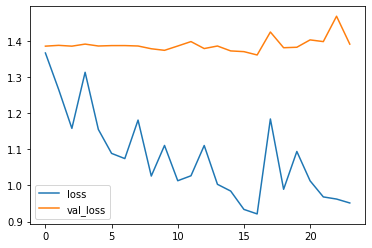

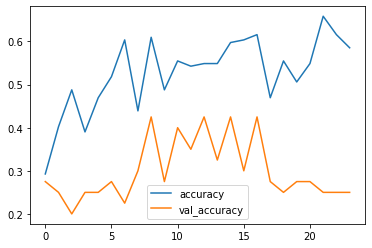

In [21]:
history=model.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [22]:
model.evaluate(val_data)

2/2 [==============================] - 3s 293ms/step - loss: 1.3769 - accuracy: 0.3750


[1.3768619298934937, 0.375]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

<AxesSubplot:>

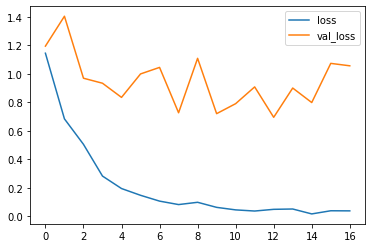

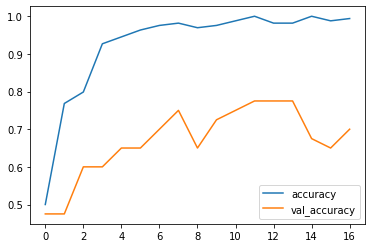

In [27]:
#transfer learning using mobilereNetV2
from keras.applications import MobileNetV2
from keras.models import Model

base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(164,activation='relu')(x)
x=Dense(64,activation='relu')(x)
pred=Dense(len(class_name),activation='softmax')(x)
model2=Model(inputs=base_model.input,outputs=pred)
for layer in base_model.layers:
    layer.trainable=False
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True)
   ]
model2.summary()
history=model2.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()


In [28]:
model2.evaluate(val_data)

2/2 [==============================] - 3s 514ms/step - loss: 0.9244 - accuracy: 0.7250


[0.9243631362915039, 0.7250000238418579]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 164)               336036    
                                                                 
 dense_19 (Dense)            (None, 64)                10560     
                                                                 
 dense_20 (Dense)            (None, 4)                 260       
                                                                 
Total params: 22,149,640
Trainable params: 346,856
Non-trainable params: 21,802,784
____________________________________

<AxesSubplot:>

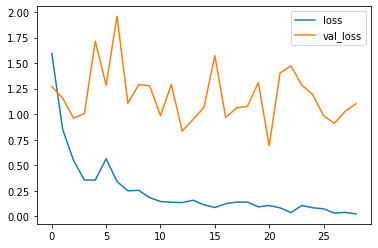

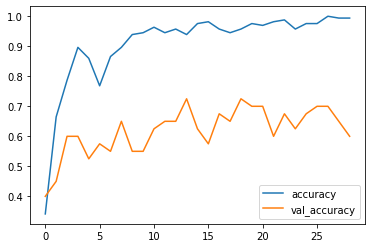

In [29]:
#transfer learning with inception
from keras.applications import InceptionV3
model3=Sequential()
model3.add(InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3)))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(164,activation='relu'))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(len(class_name),activation='softmax'))
model3.layers[0].trainable=False
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
    ]
model3.summary()

history=model3.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [30]:
model3.evaluate(val_data)

2/2 [==============================] - 3s 312ms/step - loss: 1.2797 - accuracy: 0.6000


[1.2796962261199951, 0.6000000238418579]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 164)               336036    
                                                                 
 dense_31 (Dense)            (None, 64)                10560     
                                                                 
 dense_32 (Dense)            (None, 4)                 260       
                                                                 
Total params: 23,934,568
Trainable params: 346,856
Non-trainable params: 23,587,712
____________________________________

<AxesSubplot:>

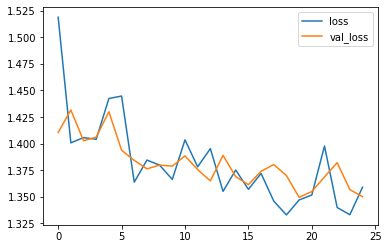

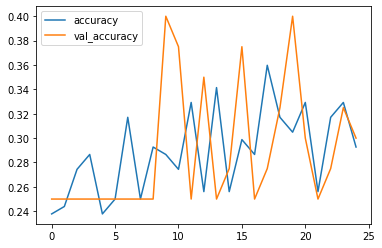

In [35]:
#transfer learning with resnet
from keras.applications import ResNet50
model4=Sequential()
model4.add(ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3)))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(164,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(len(class_name),activation='softmax'))
model4.layers[0].trainable=False
model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
    ]
model4.summary()

history=model4.fit(train_data,epochs=100,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [36]:
model4.evaluate(val_data)

2/2 [==============================] - 3s 280ms/step - loss: 1.3756 - accuracy: 0.4000


[1.375597596168518, 0.4000000059604645]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 164)               210084    
                                                                 
 dense_25 (Dense)            (None, 64)                10560     
                                                                 
 dense_26 (Dense)            (None, 4)                 260       
                                                                 
Total params: 4,270,475
Trainable params: 220,904
Non-trainable params: 4,049,571
______________________________________

<AxesSubplot:>

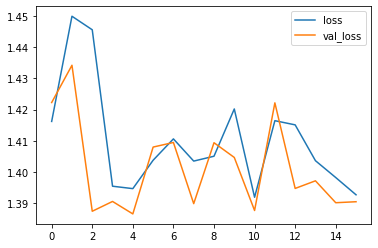

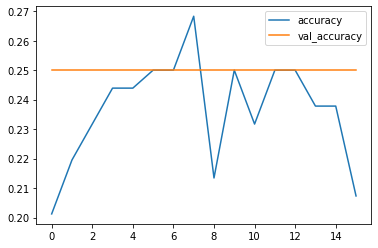

In [33]:
#model using efficientnet
from keras.applications import EfficientNetB0
model5=Sequential()
model5.add(EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3)))
model5.add(GlobalAveragePooling2D())
model5.add(Dense(164,activation='relu'))
model5.add(Dense(64,activation='relu'))
model5.add(Dense(len(class_name),activation='softmax'))
model5.layers[0].trainable=False
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
    ]
model5.summary()

history=model5.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_33 (Dense)            (None, 164)               210084    
                                                                 
 dense_34 (Dense)            (None, 64)                10560     
                                                                 
 dense_35 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20,552,264
Trainable params: 220,904
Non

<AxesSubplot:>

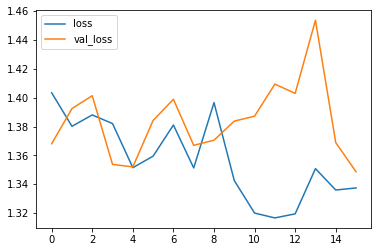

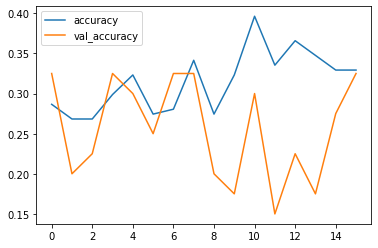

In [37]:
#model using efficientnetv2
from keras.applications import EfficientNetV2S
model6=Sequential()
model6.add(EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3)))
model6.add(GlobalAveragePooling2D())
model6.add(Dense(164,activation='relu'))
model6.add(Dense(64,activation='relu'))
model6.add(Dense(len(class_name),activation='softmax'))
model6.layers[0].trainable=False
model6.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
    ]
model6.summary()

history=model6.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

473176280/473176280 [==============================] - 110s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_36 (Dense)            (None, 164)               210084    
                                                                 
 dense_37 (Dense)            (None, 64)                10560     
                                                                 
 dense_38 (Dense)            (None, 4)                 260       
                                                   

<AxesSubplot:>

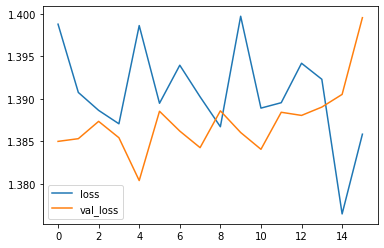

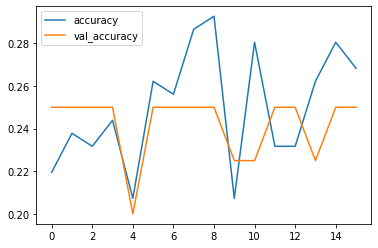

In [39]:
#using landmark model
from keras.applications import EfficientNetV2L
model7=Sequential()
model7.add(EfficientNetV2L(include_top=False,weights='imagenet',input_shape=(224,224,3)))
model7.add(GlobalAveragePooling2D())
model7.add(Dense(164,activation='relu'))
model7.add(Dense(64,activation='relu'))
model7.add(Dense(len(class_name),activation='softmax'))
model7.layers[0].trainable=False
model7.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True)
    ]
model7.summary()

history=model7.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [44]:
#save model
model2.save('model.h5')

In [ ]:
model7.evaluate(val_data)

1/1 [==============================] - 2s 2s/step - loss: 1.3631 - accuracy: 0.4074


[1.363105297088623, 0.40740740299224854]

In [40]:
from keras.utils import load_img, img_to_array
def predict(img_rel_path):
    img = load_img(img_rel_path, target_size=(224, 224))
    img = img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()
    p = model2.predict(img[np.newaxis, ...])
    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = class_name[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")
    for i,j in enumerate (p[0],0):
        print(class_name[i].upper(),':',round(j*100,2),'%')
        classes.append(class_name[i])
        prob.append(round(j*100,2))      
    def plot_bar_x():
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

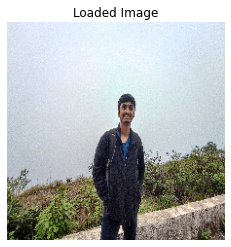

1/1 [==============================] - 0s 42ms/step


Maximum Probability:  0.99230605
Classified: swaroop 



-------------------Individual Probability--------------------------------

INTRUDER : 0.01 %
RAHUL : 0.7 %
REHAN : 0.05 %
SWAROOP : 99.23 %


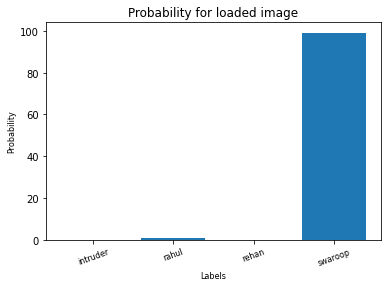

In [43]:
predict('hardware/train/swaroop/IMG_20220611_162445.jpg')

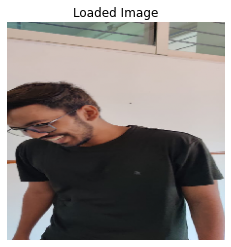

1/1 [==============================] - 0s 56ms/step


Maximum Probability:  0.9847542
Classified: rahul 



-------------------Individual Probability--------------------------------

INTRUDER : 0.14 %
RAHUL : 98.48 %
REHAN : 0.14 %
SWAROOP : 1.25 %


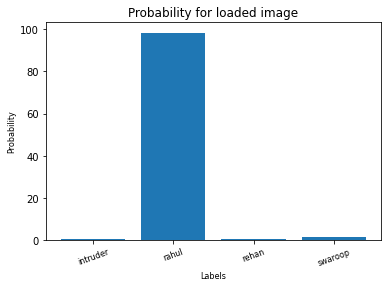

In [46]:
predict('hardware/train/rahul\WhatsApp Image 2022-10-15 at 12.20.39 PM.jpeg')

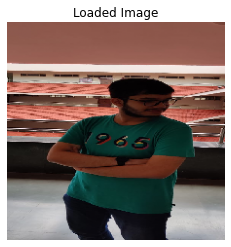

1/1 [==============================] - 0s 84ms/step


Maximum Probability:  0.97048753
Classified: rehan 



-------------------Individual Probability--------------------------------

INTRUDER : 0.01 %
RAHUL : 2.91 %
REHAN : 97.05 %
SWAROOP : 0.04 %


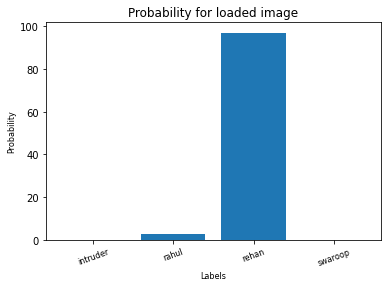

In [47]:
predict('hardware/train/rehan/WhatsApp Image 2022-10-15 at 12.20.41 PM (1).jpeg')

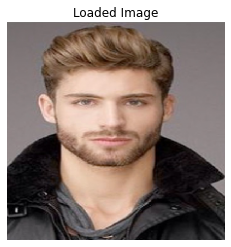

1/1 [==============================] - 0s 63ms/step


Maximum Probability:  0.97334087
Classified: intruder 



-------------------Individual Probability--------------------------------

INTRUDER : 97.33 %
RAHUL : 1.38 %
REHAN : 0.2 %
SWAROOP : 1.09 %


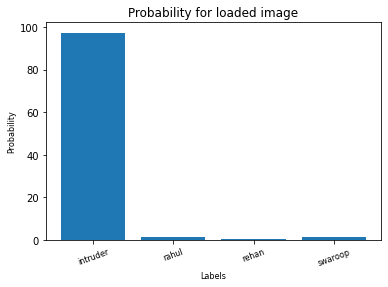

In [52]:
predict('hardware/train/intruder/1 (29).png')

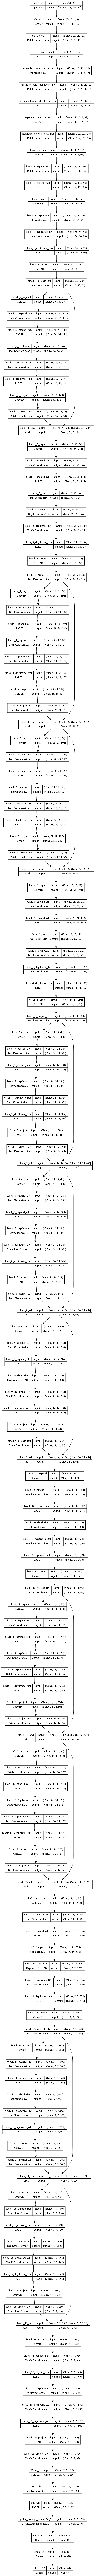

In [45]:
#illustration of model
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
